# Extra libraries annotation

The libraries were downloaded from https://littlemsandsailing.com/2023/10/free-ei-and-msms-spectra-in-nist-format/ and converted to SDF/MSP with the LIB2NIST tool.

In this notebook we annotate the spectra with SMILES strings. This information is taken from compound libraries, such as PubChem or IDSM. In order to do that we need a tool that conveniently communicates with the libraries - [MSMetaEnhancer](https://github.com/RECETOX/MSMetaEnhancer/tree/main). In the MSMetaEnhancer repository you'll find the installation instructions and instructions for setting up environment needed to run this notebook in. 

In [1]:
from matchms.importing import load_from_msp
from tqdm import tqdm
import pandas as pd
import asyncio
import nest_asyncio
from rdkit import Chem
from pathlib import Path

from MSMetaEnhancer import Application

## Helper functions

In [2]:
def annotate_spectra(original_msp_path, 
                     annotated_msp_path,
                     services=['CTS', 'CIR', 'IDSM', 'PubChem', 'BridgeDb', 'RDKit'],
                     jobs=[('compound_name', 'canonical_smiles', 'PubChem'),
                           ('compound_name', 'canonical_smiles', 'IDSM')]):
    """
    Annotate the spectra in the original_msp_path and save the annotated spectra in the annotated_msp_path.
    You can specify the services you want to use for the annotation and the jobs you want to perform.
    The jobs are a list of tuple (X, Y, Z), meaning X_to_Y using service Z. The possible X and Y 
    with respect to Z can be found in the documentation (code) of the MSMetaEnhancer.

    The code was taken and altered from the MSMetaEnhancer README example.
    """
    # Apply the nest_asyncio patch
    nest_asyncio.apply()
    app = Application()

    app.load_data(original_msp_path, file_format='msp')
    app.curate_metadata()
    asyncio.run(app.annotate_spectra(services, jobs))

    app.save_data(annotated_msp_path, file_format='msp')


def filter_unsuccessful_annotations(spectra, 
                      smiles_column_name = "canonical_smiles", 
                      check_from_smiles=[("formula", "formula"), ("molecular_weight", "mw")]):
    """
    Filter out spectra that have missing smiles, wrong formula or wrong molecular weight.
    You can specify the column name of the smiles and of the checks you want to perform.
    You can remove the check by removing the tuple from the check_from_smiles list.
    """
    bad_formula = 0
    bad_mw = 0
    missing_smiles = 0
    successful_spectra = []
    for s in spectra:
        smiles = s.metadata.get(smiles_column_name, None)
        if smiles == None:
            missing_smiles += 1
            continue

        ok = True
        for descriptor, column_name in check_from_smiles:
            desc_val = s.metadata.get(column_name, None)
            if desc_val == None:
                continue
            elif descriptor == "molecular_weight":
                mw_from_smiles = int(Chem.Descriptors.MolWt(Chem.MolFromSmiles(smiles)))
                if abs(int(desc_val) - mw_from_smiles) > 1:
                    bad_mw += 1
                    ok = False
                    print(f"Error in {s.metadata['compound_name']}, is {desc_val} but should be {mw_from_smiles}")
            elif descriptor == "formula":
                formula_from_smiles = Chem.rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(smiles))
                if formula_from_smiles != desc_val:
                    bad_formula += 1 
                    ok = False
                    print(f"Error in {s.metadata['compound_name']}, is {desc_val} but should be {formula_from_smiles}")
        if ok:     
            successful_spectra.append(s)
            
    print(f"Missing smiles: {missing_smiles}")
    print(f"Bad formula: {bad_formula}")
    print(f"Bad mw: {bad_mw}")
    return successful_spectra


def remove_stereochemistry_and_canonicalize(smiles):
    """
    Remove the stereochemistry from a smiles and canonicalize it.
    --- copied from spectra_utils.py bcs of import issues ---
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Smiles {smiles} is not valid.")
        return None
    Chem.RemoveStereochemistry(mol)
    new_smiles = Chem.MolToSmiles(mol)
    return new_smiles


def extract_spectra(spectra):
    """
    Get the m/z, intensity and smiles from a list of spectra and
    return them in a DataFrame.
    --- copied from spectra_utils.py bcs of import issues ---
    """
    mzs = []
    intensities = []
    canon_smiless = []
    for d in tqdm(spectra):
        canon_smiles = remove_stereochemistry_and_canonicalize(d.metadata["canonical_smiles"])
        if canon_smiles:
            mzs.append(d.peaks.mz)
            intensities.append(d.peaks.intensities)
            canon_smiless.append(canon_smiles)
    df_out = pd.DataFrame({"mz": mzs, "intensity": intensities, "smiles": canon_smiless})
    return df_out

## SWGDRUG: Enhance the dataset metadata
Use MSMetaEnhancer to fill in the missing SMILES string. Afterward, filter out the spectra that do not have a SMILES string or were not annotated correctly.

In [3]:
library_name = "SWGDRUG_3"

data_path = f"datasets/extra_libraries/{library_name}/{library_name}.MSP"
annotated_data_path = f"datasets/extra_libraries/{library_name}/{library_name}_annotated.MSP"
output_jsonl = f"datasets/extra_libraries/{library_name}/{library_name}.jsonl"

In [73]:
annotate_spectra(data_path, annotated_data_path)

2024-09-16 17:10:27,627:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,628:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,629:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,630:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,631:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,632:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,633:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,634:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,634:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,635:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 17:10:27,636:WARNING:matchms:add_precursor_mz:No precursor_mz found i

In [57]:
spectra_annotated = list(load_from_msp(annotated_data_path))

2024-09-16 15:57:55,516:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,517:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,518:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,519:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,520:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,521:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,522:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,523:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,524:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,525:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 15:57:55,526:WARNING:matchms:add_precursor_mz:No precursor_mz found i

In [58]:
clean_spectra_annotated = filter_unsuccessful_annotations(spectra_annotated)

Error in Clidinium, is C22H26NO3 but should be C22H26NO3+
Error in DDT, is 352 but should be 354
Error in Lindane, is 288 but should be 290
Error in Ambroxol, is 376 but should be 378
Error in Meperidine-d5, is C15H16D5NO2 but should be C15H21NO2
Error in Meperidine-d5, is 252 but should be 247
Error in PCP-d5, is C17H20D5N but should be C17H25N
Error in PCP-d5, is 248 but should be 243
Error in Alprazolam-d3, is C17H10D3ClN4 but should be C17H13ClN4
Error in Alprazolam-d3, is 311 but should be 308
Error in Diazepam-d3, is C16H10D3ClN2O but should be C16H13ClN2O
Error in Diazepam-d3, is 287 but should be 284
Error in Dextromethorphan-d3, is C18H22D3NO but should be C18H25NO
Error in Dextromethorphan-d3, is 274 but should be 271
Error in Nordiazepam-d5, is C15H6D5ClN2O but should be C15H11ClN2O
Error in Nordiazepam-d5, is 275 but should be 270
Error in Alprazolam-d8, is C17H5D8ClN4 but should be C17H13ClN4
Error in Alprazolam-d8, is 316 but should be 308
Error in Temazepam-d8, is C16H5D

In [71]:
print(f"Extracted {len(clean_spectra_annotated)}/{len(spectra_annotated)} spectra") 

Extracted 3321/3321 spectra


### SWGDRUGS: Remove overlaps with NIST and SYNTH train set

In [61]:
canonical_swg_smiles = [remove_stereochemistry_and_canonicalize(s.metadata["canonical_smiles"]) for s in tqdm(clean_spectra_annotated)]

100%|██████████| 3321/3321 [00:01<00:00, 2446.17it/s]


In [62]:
## !!!!!!!!! THIS IS FOR DEUTERIUM HANDLING
spectra_annotated = clean_spectra_annotated

In [46]:
NIST_TRAIN_PATH = '../clean_paper/data/nist/train.jsonl'
NIST_TEST_PATH = '../clean_paper/data/nist/test.jsonl'
NIST_VAL_PATH = '../clean_paper/data/nist/valid.jsonl'

NEIMS_TRAIN_PATH = '../clean_paper/data/synth/neims_gen/train.jsonl'
OLD_NEIMS_TRAIN_PATH = '../data/datasets/4_8M/neims_gen/train.jsonl'

In [47]:
nist_train = pd.read_json(NIST_TRAIN_PATH, lines=True, orient='records')
nist_test = pd.read_json(NIST_TEST_PATH, lines=True, orient='records')
nist_valid = pd.read_json(NIST_VAL_PATH, lines=True, orient='records')

neims_train = pd.read_json(NEIMS_TRAIN_PATH, lines=True, orient='records')
old_neims_train = pd.read_json(OLD_NEIMS_TRAIN_PATH, lines=True, orient='records')

In [63]:
nist_train_set = set(nist_train.smiles)
nist_test_set = set(nist_test.smiles)
nist_valid_set = set(nist_valid.smiles)
neims_train_set = set(neims_train.smiles)
old_neims_train_set = set(old_neims_train.smiles)
canonical_swg_smiles_set = set(canonical_swg_smiles)

notallowed_smiles_set = nist_train_set.union(nist_test_set).union(nist_valid_set).union(neims_train_set).union(old_neims_train_set)
allowed_smiles_set = canonical_swg_smiles_set.difference(notallowed_smiles_set)

print(f"overlap of swg and nist train: {len(canonical_swg_smiles_set.intersection(nist_train_set))}")
print(f"overlap of swg and nist test: {len(canonical_swg_smiles_set.intersection(nist_test_set))}")
print(f"overlap of swg and nist valid: {len(canonical_swg_smiles_set.intersection(nist_valid_set))}")
print(f"overlap of swg and neims train: {len(canonical_swg_smiles_set.intersection(neims_train_set))}")
print(f"overlap of swg and old neims train: {len(canonical_swg_smiles_set.intersection(old_neims_train_set))}")

print(f"unique swg: {len(canonical_swg_smiles_set)}")

print(f"unique swg without leaks: {len(allowed_smiles_set)}")

overlap of swg and nist train: 1557
overlap of swg and nist test: 191
overlap of swg and nist valid: 189
overlap of swg and neims train: 11
overlap of swg and old neims train: 29
unique swg: 3197
unique swg without leaks: 1245


In [64]:
allowed_spectra = []
for s in tqdm(spectra_annotated):
    if remove_stereochemistry_and_canonicalize(s.metadata["canonical_smiles"]) in allowed_smiles_set:
        allowed_spectra.append(s)

100%|██████████| 3321/3321 [00:01<00:00, 2851.50it/s]


In [66]:
len(allowed_spectra)

1275

In [68]:
df = extract_spectra(allowed_spectra)
df["mz"] = df["mz"].apply(lambda x: list(x.round(0)))
# path_jsonl = Path(data_path).with_suffix(".jsonl")   # correct
path_jsonl = Path(data_path).parent / Path(Path(data_path).stem + "_noD.jsonl")  # test noD
df.to_json(path_jsonl, orient="records", lines=True)

100%|██████████| 1275/1275 [00:00<00:00, 2579.37it/s]


---------------------------------------------------------------------------

## Use this pipeline for all the other libraries

In [3]:
library_name = "Cayman_library"

data_path = f"datasets/extra_libraries/{library_name}/{library_name}.MSP"
annotated_data_path = f"datasets/extra_libraries/{library_name}/{library_name}_annotated.MSP"
output_jsonl = f"datasets/extra_libraries/{library_name}/{library_name}.jsonl"

In [4]:
# ~ 9mins for Cayman_library
annotate_spectra(data_path, annotated_data_path,
                 jobs=[('compound_name', 'canonical_smiles', 'PubChem'),
                       ('compound_name', 'canonical_smiles', 'IDSM'),
                       ('inchikey', 'canonical_smiles', 'PubChem')])

2024-09-16 18:27:03,909:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,910:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,911:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,912:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,913:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,915:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,916:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,917:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,917:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,918:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:27:03,919:WARNING:matchms:add_precursor_mz:No precursor_mz found i

In [5]:
spectra_annotated = list(load_from_msp(annotated_data_path))

2024-09-16 18:37:44,434:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,436:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,437:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,438:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,440:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,441:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,442:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,443:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,444:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,444:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-09-16 18:37:44,445:WARNING:matchms:add_precursor_mz:No precursor_mz found i

In [6]:
clean_spectra_annotated = filter_unsuccessful_annotations(spectra_annotated)

Error in Temazepam-d8, is C16H5D8ClN2O2 but should be C16H13ClN2O2
Error in Temazepam-d8, is 308 but should be 300
Error in Desmethylmoramide, is C20H26N2O but should be C24H30N2O2
Error in Desmethylmoramide, is 310 but should be 378
Error in Metonitazene-d3, is C21H23D3N4O3 but should be C21H26N4O3
Error in Metonitazene-d3, is 385 but should be 382
Error in Flubromazolam-d4, is C17H8D4BrFN4 but should be C17H12BrFN4
Error in Flubromazolam-d4, is 374 but should be 371
Error in Flubromazepam-d4, is C15H6D4BrFN2O but should be C15H10BrFN2O
Error in Flubromazepam-d4, is 336 but should be 333
Error in Brorphine-d7, is C20H15D7BrN3O but should be C20H22BrN3O
Error in Brorphine-d7, is 406 but should be 400
Error in Methoxisopropamine, is C15H21NO2 but should be C16H23NO2
Error in Methoxisopropamine, is 247 but should be 261
Error in Cannabigerol-d9, is C21H23D9O2 but should be C21H32O2
Error in Cannabigerol-d9, is 325 but should be 316
Error in Fludiazepam-d4, is C16H8D4ClFN2O but should be 

In [7]:
print(f"Extracted {len(clean_spectra_annotated)}/{len(spectra_annotated)} spectra") 

Extracted 1745/2262 spectra


### Remove overlaps with NIST and SYNTH train set

In [8]:
canonical_swg_smiles = [remove_stereochemistry_and_canonicalize(s.metadata["canonical_smiles"]) for s in tqdm(clean_spectra_annotated)]

  0%|          | 0/1745 [00:00<?, ?it/s]

100%|██████████| 1745/1745 [00:00<00:00, 3119.96it/s]


In [11]:
## !!!!!!!!! THIS IS FOR DEUTERIUM HANDLING
spectra_annotated = clean_spectra_annotated

In [12]:
NIST_TRAIN_PATH = '../clean_paper/data/nist/train.jsonl'
NIST_TEST_PATH = '../clean_paper/data/nist/test.jsonl'
NIST_VAL_PATH = '../clean_paper/data/nist/valid.jsonl'

NEIMS_TRAIN_PATH = '../clean_paper/data/synth/neims_gen/train.jsonl'
OLD_NEIMS_TRAIN_PATH = '../data/datasets/4_8M/neims_gen/train.jsonl'

In [13]:
nist_train = pd.read_json(NIST_TRAIN_PATH, lines=True, orient='records')
nist_test = pd.read_json(NIST_TEST_PATH, lines=True, orient='records')
nist_valid = pd.read_json(NIST_VAL_PATH, lines=True, orient='records')

neims_train = pd.read_json(NEIMS_TRAIN_PATH, lines=True, orient='records')
old_neims_train = pd.read_json(OLD_NEIMS_TRAIN_PATH, lines=True, orient='records')

In [14]:
nist_train_set = set(nist_train.smiles)
nist_test_set = set(nist_test.smiles)
nist_valid_set = set(nist_valid.smiles)
neims_train_set = set(neims_train.smiles)
old_neims_train_set = set(old_neims_train.smiles)
canonical_swg_smiles_set = set(canonical_swg_smiles)

notallowed_smiles_set = nist_train_set.union(nist_test_set).union(nist_valid_set).union(neims_train_set).union(old_neims_train_set)
allowed_smiles_set = canonical_swg_smiles_set.difference(notallowed_smiles_set)

print(f"overlap of swg and nist train: {len(canonical_swg_smiles_set.intersection(nist_train_set))}")
print(f"overlap of swg and nist test: {len(canonical_swg_smiles_set.intersection(nist_test_set))}")
print(f"overlap of swg and nist valid: {len(canonical_swg_smiles_set.intersection(nist_valid_set))}")
print(f"overlap of swg and neims train: {len(canonical_swg_smiles_set.intersection(neims_train_set))}")
print(f"overlap of swg and old neims train: {len(canonical_swg_smiles_set.intersection(old_neims_train_set))}")

print(f"unique swg: {len(canonical_swg_smiles_set)}")

print(f"unique swg without leaks: {len(allowed_smiles_set)}")

overlap of swg and nist train: 725
overlap of swg and nist test: 88
overlap of swg and nist valid: 89
overlap of swg and neims train: 6
overlap of swg and old neims train: 17
unique swg: 1653
unique swg without leaks: 743


In [15]:
allowed_spectra = []
for s in tqdm(spectra_annotated):
    if remove_stereochemistry_and_canonicalize(s.metadata["canonical_smiles"]) in allowed_smiles_set:
        allowed_spectra.append(s)

100%|██████████| 1745/1745 [00:00<00:00, 2844.30it/s]


In [16]:
len(allowed_spectra)

766

In [17]:
df = extract_spectra(allowed_spectra)
df["mz"] = df["mz"].apply(lambda x: list(x.round(0)))
# path_jsonl = Path(data_path).with_suffix(".jsonl")   # correct
path_jsonl = Path(data_path).parent / Path(Path(data_path).stem + "_noD.jsonl")  # test noD
df.to_json(path_jsonl, orient="records", lines=True)

100%|██████████| 766/766 [00:02<00:00, 354.90it/s] 


## playground

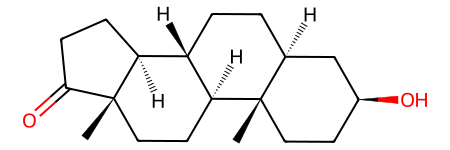

In [10]:
# ssmaz
from rdkit import Chem

Chem.MolFromSmiles("C[C@]12CC[C@@H](C[C@@H]1CC[C@@H]3[C@@H]2CC[C@]4([C@H]3CCC4=O)C)O")

In [26]:
mask = nist_train.smiles.apply(lambda x: "D" in x)
nist_train[mask]

,mz,intensity,smiles
